In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import time
import tensorflow as tf
from random import shuffle
import glob

/usr/local/python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['STFangsong']
mpl.rcParams['figure.figsize'] = (20, 3)

In [25]:
%matplotlib inline

In [4]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

from object_detection.utils import ops as utils_ops

In [20]:
from numbers import Real
def to_severity(lesions_num:Real) -> int:
    """
    The Hayashi criterion
    The appropriate divisions of inflammatory eruptions of half of the face to decide classifications were:     0-5, "mild";
        6-20, "moderate";
        21-50, "severe";
        >=50, "very severe"
    Reference:
    [1] Hayashi N, Akamatsu H, Kawashima M, et al. Establishment of grading criteria for acne severity[J]. The Journal of dermatology, 2008, 35(5): 255-260.
    [2] https://www.ncbi.nlm.nih.gov/pubmed/18477223
    """
    if lesions_num <= 5:
        return 0
    elif lesions_num <= 20:
        return 1
    elif lesions_num <= 50:
        return 2
    else:
        return 3

def nms_cpu(boxes, confs, nms_thresh=0.5, min_mode=False):
    # print(boxes.shape)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = confs.argsort()[::-1]

    keep = []
    while order.size > 0:
        idx_self = order[0]
        idx_other = order[1:]

        keep.append(idx_self)

        xx1 = np.maximum(x1[idx_self], x1[idx_other])
        yy1 = np.maximum(y1[idx_self], y1[idx_other])
        xx2 = np.minimum(x2[idx_self], x2[idx_other])
        yy2 = np.minimum(y2[idx_self], y2[idx_other])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h

        if min_mode:
            over = inter / np.minimum(areas[order[0]], areas[order[1:]])
        else:
            over = inter / (areas[order[0]] + areas[order[1:]] - inter)

        inds = np.where(over <= nms_thresh)[0]
        order = order[inds + 1]
    
    return np.array(keep)

In [6]:
parent_dir = "/export/servers/wenhao/acne_detection_new/faster_rcnn_inception_v2/latest_models/"

In [7]:
faster_rcnn_resnet101_large_frozen_graph = os.path.join(parent_dir, "faster_rcnn_inception_v2_latest/frozen_inference_graph.pb")

In [8]:
PATH_TO_FROZEN_GRAPH = faster_rcnn_resnet101_large_frozen_graph

PATH_TO_LABELS = '/export/servers/data/acne_article_data/acne.pbtxt'

In [9]:
PATH_TO_FROZEN_GRAPH

'/export/servers/wenhao/acne_detection_new/faster_rcnn_inception_v2/latest_models/faster_rcnn_inception_v2_latest/frozen_inference_graph.pb'

In [10]:
os.path.exists(PATH_TO_FROZEN_GRAPH)

True

In [11]:
os.path.isfile(PATH_TO_FROZEN_GRAPH)

True

## faster_rcnn_resnet101_large

In [12]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [13]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=1, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [14]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [ 'num_detections', 'detection_boxes', 'detection_scores', 'detection_classes', 'detection_masks' ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims( detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [15]:
def detect_and_draw_old(image_path=None, face_img=None, min_score_thresh=0.5, show=False):
    if image_path is not None:
        if not os.path.exists(image_path):
            return

        print(image_path.split("/")[-1])
        #   image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        #   image_np = load_image_into_numpy_array(image)
        image = cv2.imread(image_path)[...,::-1]
        image_np = cv2.imread(image_path)[...,::-1]
        image_origin = cv2.imread(image_path)[...,::-1]
    elif face_img is not None:
        image = face_img.copy()
        image_np = face_img.copy()
        image_origin = face_img.copy()
    else:
        raise ValueError
    print(image.size, image_np.shape, image_origin.shape)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    
    start = time.time()
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    print('detection cost {} second(s)'.format(time.time()-start))
    
    detected_indices = np.where(output_dict['detection_scores'] >= min_score_thresh)[0]
    detected_scores = output_dict['detection_scores'][detected_indices]
    detected_boxes = output_dict['detection_boxes'][detected_indices]
    
    fl_w, fl_h = image.shape[:2]
    mask_acne = np.zeros(shape=(fl_w, fl_h), dtype=np.uint8)
    for ymin, xmin, ymax, xmax in detected_boxes:
        ymin, xmin, ymax, xmax = int(round(ymin*fl_w)), int(round(xmin*fl_h)), int(round(ymax*fl_w)), int(round(xmax*fl_h))
        mask_acne[ymin:ymax, xmin:xmax] = 1
    _, labels = cv2.connectedComponents(mask_acne, 1, 4)
    labels = np.unique(labels)
    acne_num = max(0, len(labels) - 1)
    detected_acne_num = acne_num
    
    if not show:
        return detected_scores, detected_boxes, detected_acne_num
    
#     print("output_dict = ", output_dict)
    # Visualization of the results of a detection.
    image = vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      min_score_thresh=min_score_thresh,
      line_thickness=10
    )
#     print(output_dict['detection_boxes'])
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    plt.show()
    
    return detected_scores, detected_boxes, detected_acne_num

In [16]:
def detect_and_draw(image_path=None, face_img=None, min_score_thresh=0.5, show=False, **kwargs):
    if image_path is not None:
        if not os.path.exists(image_path):
            return
        print(image_path.split("/")[-1])
        image = cv2.imread(image_path)[...,::-1]
    elif face_img is not None:
        image = face_img.copy()
    else:
        raise ValueError
    print(image.shape)
    
    # Actual detection.
    start = time.time()
    output_dict = run_inference_for_single_image(image, detection_graph)
    print('detection cost {} second(s)'.format(time.time()-start))
    
    detected_indices = np.where(output_dict['detection_scores'] >= min_score_thresh)[0]
    detected_scores = output_dict['detection_scores'][detected_indices]
    detected_boxes = output_dict['detection_boxes'][detected_indices]
    
    fl_w, fl_h = image.shape[:2]
    mask_acne = np.zeros(shape=(fl_w, fl_h), dtype=np.uint8)
    img_with_boxes = image.copy()
    line_size = max(1, int(max(img_with_boxes.shape[:2]) / 500))
    for ymin, xmin, ymax, xmax in detected_boxes:
        ymin, xmin, ymax, xmax = int(round(ymin*fl_w)), int(round(xmin*fl_h)), int(round(ymax*fl_w)), int(round(xmax*fl_h))
        mask_acne[ymin:ymax, xmin:xmax] = 1
        cv2.rectangle(img_with_boxes, (xmin, ymin), (xmax, ymax), (0, 255, 0), line_size)
    _, labels = cv2.connectedComponents(mask_acne, 1, 4)
    labels = np.unique(labels)
    acne_num = max(0, len(labels) - 1)
    detected_acne_num = acne_num
    
    if not show:
        return detected_scores, detected_boxes, detected_acne_num
    
    # Visualization of the results of a detection.
    title = kwargs.get("title", None)
    plt.figure(figsize=kwargs.get("figsize", (9, 9)))
    plt.imshow(img_with_boxes)
    plt.axis("off")
    if title:
        plt.title(title+f'\ndetected number {detected_acne_num}', y=-0.1, fontsize=20)
#         plt.xlabel(title+f'\n{detected_acne_num}', fontsize=20)
    if kwargs.get("savefig", False):
        fmt = kwargs.get("fmt", "png")
        plt.savefig(f"./fig/{title or str(int(time.time()))}.{fmt}", bbox_inches='tight', transparent=True)

    plt.show()
    
    return detected_scores, detected_boxes, detected_acne_num

In [17]:
def detect(image_path=None, face_img=None, min_score_thresh=[0.5]):
    if image_path is not None:
        if not os.path.exists(image_path):
            return

        print(image_path.split("/")[-1])
        #   image = Image.open(image_path)
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        #   image_np = load_image_into_numpy_array(image)
        image = cv2.imread(image_path)[...,::-1]
        image_np = cv2.imread(image_path)[...,::-1]
        image_origin = cv2.imread(image_path)[...,::-1]
    elif face_img is not None:
        image = face_img.copy()
        image_np = face_img.copy()
        image_origin = face_img.copy()
    else:
        raise ValueError
    print(image.size, image_np.shape, image_origin.shape)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    
    start = time.time()
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    print('detection cost {} second(s)'.format(time.time()-start))
    
    detected_indices, detected_scores, detected_boxes, detected_acne_num = {}, {}, {}, {}
    
    for mst in min_score_thresh:
        detected_indices[mst] = np.where(output_dict['detection_scores'] >= mst)[0]
        detected_scores[mst] = output_dict['detection_scores'][detected_indices[mst]]
        detected_boxes[mst] = output_dict['detection_boxes'][detected_indices[mst]]
        
        fl_w, fl_h = image.shape[:2]
        mask_acne = np.zeros(shape=(fl_w, fl_h), dtype=np.uint8)
        for ymin, xmin, ymax, xmax in detected_boxes[mst]:
            ymin, xmin, ymax, xmax = int(round(ymin*fl_w)), int(round(xmin*fl_h)), int(round(ymax*fl_w)), int(round(xmax*fl_h))
            mask_acne[ymin:ymax, xmin:xmax] = 1
        _, labels = cv2.connectedComponents(mask_acne, 1, 4)
        labels = np.unique(labels)
        acne_num = max(0, len(labels) - 1)
        detected_acne_num[mst] = acne_num
    
    return detected_scores, detected_boxes, detected_acne_num

In [18]:
filtered_image_path = "/export/servers/data/acne_article_data/filtered_images/"

all_fi = [os.path.join(filtered_image_path, item) for item in os.listdir(filtered_image_path)]

# all_fi

In [19]:
len(all_fi)

1229

In [21]:
os.path.basename(all_fi[0])

'levle0_1.jpg'

levle1_619.jpg
(3456, 3112, 3)
detection cost 1.5706181526184082 second(s)


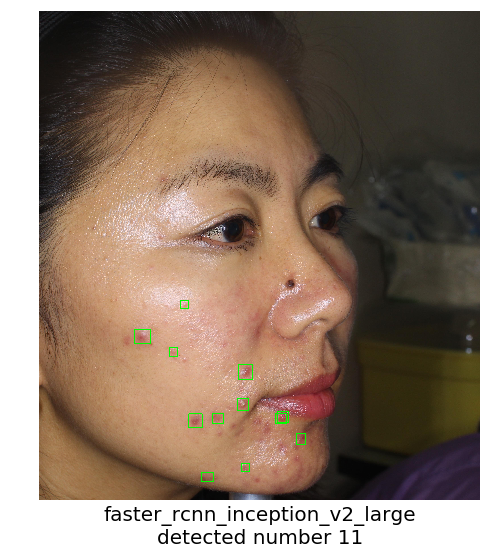

(array([0.99872285, 0.995272  , 0.9828303 , 0.9768469 , 0.9662905 ,
        0.948362  , 0.922228  , 0.6948211 , 0.67835635, 0.6457096 ,
        0.58529   , 0.5047652 ], dtype=float32),
 array([[0.7233153 , 0.45138305, 0.7537024 , 0.4840744 ],
        [0.82349294, 0.33977264, 0.85186386, 0.36955377],
        [0.6512306 , 0.21579924, 0.6805824 , 0.2517383 ],
        [0.7925171 , 0.44948742, 0.8164512 , 0.47564486],
        [0.9247949 , 0.45886913, 0.9413048 , 0.4771285 ],
        [0.86498284, 0.5832097 , 0.8865576 , 0.6048716 ],
        [0.68765485, 0.29547688, 0.70662516, 0.31426975],
        [0.8239202 , 0.5355902 , 0.8436697 , 0.560255  ],
        [0.82292473, 0.3934972 , 0.8447376 , 0.41719434],
        [0.5929292 , 0.3197546 , 0.6088551 , 0.33884904],
        [0.94388324, 0.36830822, 0.9611635 , 0.39582947],
        [0.819759  , 0.540293  , 0.8417249 , 0.5655715 ]], dtype=float32),
 11)

In [26]:
detect_and_draw(all_fi[1000],show=True,title='faster_rcnn_inception_v2_large',savefig=False)

levle0_1.jpg
(3456, 3112, 3)
detection cost 1.5602352619171143 second(s)


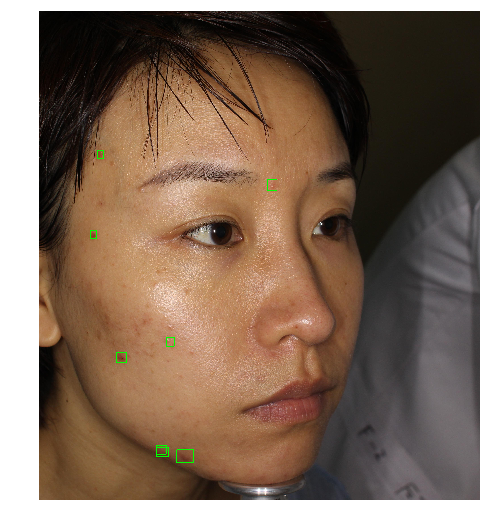

In [28]:
hehe_scores, hehe_boxes, _ = detect_and_draw(all_fi[0], min_score_thresh=0.25, show=True)

In [29]:
hehe_boxes

array([[0.8976631 , 0.31211084, 0.9236375 , 0.35128742],
       [0.34658882, 0.5171154 , 0.36909562, 0.53949356],
       [0.69843024, 0.17443529, 0.7195672 , 0.19841656],
       [0.45090157, 0.11644692, 0.46664765, 0.13124087],
       [0.28662246, 0.1313435 , 0.30362245, 0.14591442],
       [0.88900536, 0.26574677, 0.90625983, 0.28830236],
       [0.8921682 , 0.26697433, 0.91160583, 0.29305625],
       [0.6674564 , 0.28864852, 0.6858077 , 0.30672798]], dtype=float32)

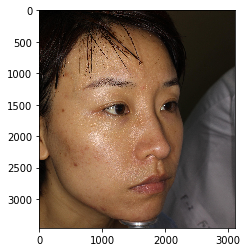

In [30]:
img_test = cv2.imread(all_fi[0])[...,::-1]
plt.imshow(img_test)

In [31]:
fl_w, fl_h = img_test.shape[:2]
fl_w, fl_h

(3456, 3112)

In [32]:
mask_acne = np.zeros(shape=(fl_w, fl_h), dtype=np.uint8)
img_with_boxes = img_test.copy()
for ymin, xmin, ymax, xmax in hehe_boxes:
    ymin, xmin, ymax, xmax = int(round(ymin*fl_w)), int(round(xmin*fl_h)), int(round(ymax*fl_w)), int(round(xmax*fl_h))
    mask_acne[ymin:ymax, xmin:xmax] = 1
    cv2.rectangle(img_with_boxes, (xmin, ymin), (xmax, ymax), (0, 255, 0), 10)

In [33]:
mask_acne.shape

(3456, 3112)

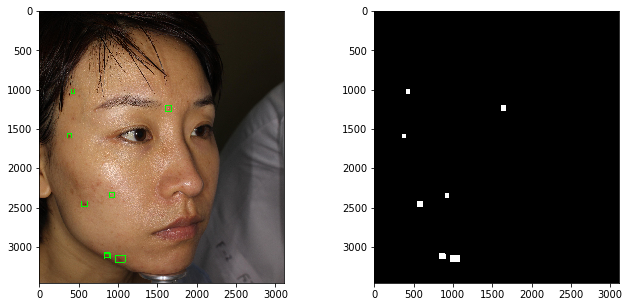

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11,5))
ax1.imshow(img_with_boxes)
ax2.imshow(mask_acne,cmap='gray')
plt.show()

In [35]:
_, labels = cv2.connectedComponents(mask_acne, 1, 4)
labels = np.unique(labels)
acne_num = max(0, len(labels) - 1)
acne_num

7

In [36]:
detect(all_fi[0], min_score_thresh=[0.1,0.25,0.5,0.75])

levle0_1.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5661242008209229 second(s)


({0.1: array([0.9978734 , 0.9890043 , 0.9834774 , 0.91319   , 0.686117  ,
         0.5135308 , 0.3510178 , 0.30314997, 0.24595506], dtype=float32),
  0.25: array([0.9978734 , 0.9890043 , 0.9834774 , 0.91319   , 0.686117  ,
         0.5135308 , 0.3510178 , 0.30314997], dtype=float32),
  0.5: array([0.9978734, 0.9890043, 0.9834774, 0.91319  , 0.686117 , 0.5135308],
        dtype=float32),
  0.75: array([0.9978734, 0.9890043, 0.9834774, 0.91319  ], dtype=float32)},
 {0.1: array([[0.8976631 , 0.31211084, 0.9236375 , 0.35128742],
         [0.34658882, 0.5171154 , 0.36909562, 0.53949356],
         [0.69843024, 0.17443529, 0.7195672 , 0.19841656],
         [0.45090157, 0.11644692, 0.46664765, 0.13124087],
         [0.28662246, 0.1313435 , 0.30362245, 0.14591442],
         [0.88900536, 0.26574677, 0.90625983, 0.28830236],
         [0.8921682 , 0.26697433, 0.91160583, 0.29305625],
         [0.6674564 , 0.28864852, 0.6858077 , 0.30672798],
         [0.888664  , 0.25388718, 0.90740985, 0.27771527

In [37]:
df_ann = pd.read_csv('/export/servers/data/acne/annotations_comprehensive.csv')

In [38]:
df_ann['img_ori_name'] = df_ann['img_filename'].apply(lambda fn:fn.replace("level", "levle"))

In [39]:
df_ann = df_ann[['img_ori_name','acne_lesion_num','severity_level']]

In [40]:
df_ann = df_ann[df_ann['img_ori_name'].isin([os.path.basename(item) for item in all_fi])].reset_index(drop=True)

In [41]:
df_ann

,img_ori_name,acne_lesion_num,severity_level
0,levle0_451.jpg,2,0
1,levle0_498.jpg,1,0
2,levle0_485.jpg,3,0
3,levle0_218.jpg,2,0
4,levle1_344.jpg,4,0
5,levle0_302.jpg,2,0
6,levle1_413.jpg,4,0
7,levle0_210.jpg,2,0
8,levle0_83.jpg,1,0
9,levle0_319.jpg,2,0


In [42]:
to_test_images = df_ann['img_ori_name'].values.tolist()

In [43]:
len(to_test_images)

1222

In [46]:
res_90 = {fn:0 for fn in to_test_images}
res_75 = {fn:0 for fn in to_test_images}
res_50 = {fn:0 for fn in to_test_images}
res_25 = {fn:0 for fn in to_test_images}
res_10 = {fn:0 for fn in to_test_images}

In [47]:
for fn in to_test_images:
    fp = os.path.join(filtered_image_path, fn)
    _, _, num = detect(fp, min_score_thresh=[0.1,0.25,0.5,0.75,0.9])
#     scores,_ = detect_and_draw(fp, min_score_thresh=0.75, show=False)
    res_90[fn] = num[0.9]
    res_75[fn] = num[0.75]
    res_50[fn] = num[0.5]
    res_25[fn] = num[0.25]
    res_10[fn] = num[0.1]

levle0_451.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6243219375610352 second(s)
levle0_498.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6562819480895996 second(s)
levle0_485.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6296427249908447 second(s)
levle0_218.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6754262447357178 second(s)
levle1_344.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6588642597198486 second(s)
levle0_302.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6542036533355713 second(s)
levle1_413.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6913330554962158 second(s)
levle0_210.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.596205472946167 second(s)
levle0_83.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 1.653602123260498 second(s)
levle0_319.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.62123703956604 second(s)
levle

detection cost 1.962207555770874 second(s)
levle0_354.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.8669426441192627 second(s)
levle0_142.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.848947525024414 second(s)
levle0_16.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.8712644577026367 second(s)
levle0_449.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.8761317729949951 second(s)
levle0_335.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.5853395462036133 second(s)
levle0_377.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.871358871459961 second(s)
levle0_389.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.280195951461792 second(s)
levle0_240.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5827865600585938 second(s)
levle0_467.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.584362506866455 second(s)
levle0_436.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detect

levle1_99.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 1.6778371334075928 second(s)
levle1_91.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 1.6644673347473145 second(s)
levle1_82.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 1.681079626083374 second(s)
levle1_576.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5763044357299805 second(s)
levle1_515.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5967869758605957 second(s)
levle1_472.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5797746181488037 second(s)
levle1_615.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.576328992843628 second(s)
levle1_192.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5684683322906494 second(s)
levle2_86.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6027965545654297 second(s)
levle1_385.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5797295570373535 second(s)
levle1

detection cost 1.7746245861053467 second(s)
levle0_113.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.843310832977295 second(s)
levle0_385.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.8376307487487793 second(s)
levle0_267.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.9776229858398438 second(s)
levle0_216.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.0112524032592773 second(s)
levle0_89.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.9031028747558594 second(s)
levle0_190.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5925488471984863 second(s)
levle0_172.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5784270763397217 second(s)
levle0_160.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.56679105758667 second(s)
levle0_516.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.578418493270874 second(s)
levle0_45.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detect

levle0_259.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5834708213806152 second(s)
levle0_55.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5942966938018799 second(s)
levle0_316.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5844285488128662 second(s)
levle0_399.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.580665111541748 second(s)
levle0_330.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6290555000305176 second(s)
levle1_559.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5848374366760254 second(s)
levle0_157.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6662654876708984 second(s)
levle1_157.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.583486795425415 second(s)
levle1_319.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.595564603805542 second(s)
levle1_612.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5884819030761719 second(s)
levl

detection cost 1.6767139434814453 second(s)
levle1_398.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5734736919403076 second(s)
levle1_269.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.21689510345459 second(s)
levle1_274.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.579580545425415 second(s)
levle1_231.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.246347427368164 second(s)
levle1_599.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6127903461456299 second(s)
levle1_185.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6096367835998535 second(s)
levle1_287.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.602473497390747 second(s)
levle1_384.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6198961734771729 second(s)
levle1_364.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.7016122341156006 second(s)
levle1_250.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detec

levle0_248.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6468052864074707 second(s)
levle1_457.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.590278148651123 second(s)
levle0_494.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.9666895866394043 second(s)
levle0_188.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5930488109588623 second(s)
levle0_120.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.579422950744629 second(s)
levle0_40.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5858516693115234 second(s)
levle0_320.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6095514297485352 second(s)
levle0_261.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.0511624813079834 second(s)
levle0_1.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.049541473388672 second(s)
levle0_315.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.059361696243286 second(s)
levle0_

detection cost 1.7470808029174805 second(s)
levle0_378.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5658693313598633 second(s)
levle0_345.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5898759365081787 second(s)
levle0_169.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.5676040649414062 second(s)
levle0_321.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5961592197418213 second(s)
levle0_386.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.9058682918548584 second(s)
levle0_171.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.584258794784546 second(s)
levle0_290.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.589052677154541 second(s)
levle0_327.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.227499008178711 second(s)
levle0_419.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5599884986877441 second(s)
levle0_243.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
det

levle1_327.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6610264778137207 second(s)
levle1_303.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.1088852882385254 second(s)
levle1_328.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6032423973083496 second(s)
levle1_455.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6050357818603516 second(s)
levle1_636.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.784538984298706 second(s)
levle1_517.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5698161125183105 second(s)
levle1_538.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.1990303993225098 second(s)
levle1_81.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 1.6716582775115967 second(s)
levle1_557.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6078367233276367 second(s)
levle1_254.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.233212947845459 second(s)
lev

detection cost 1.5633633136749268 second(s)
levle0_402.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.111175298690796 second(s)
levle0_124.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.560697078704834 second(s)
levle0_523.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6467721462249756 second(s)
levle0_221.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.704575777053833 second(s)
levle0_448.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.0276577472686768 second(s)
levle0_206.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5661652088165283 second(s)
levle0_283.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5718824863433838 second(s)
levle0_358.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.2887535095214844 second(s)
levle0_35.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5655333995819092 second(s)
levle0_528.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
dete

levle0_493.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6055083274841309 second(s)
levle0_182.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.1060643196105957 second(s)
levle0_212.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5689644813537598 second(s)
levle0_85.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 1.7295303344726562 second(s)
levle0_362.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.1872353553771973 second(s)
levle1_236.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5781166553497314 second(s)
levle1_280.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.1524763107299805 second(s)
levle1_566.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5510008335113525 second(s)
levle1_314.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.596095323562622 second(s)
levle1_433.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.8422133922576904 second(s)
le

detection cost 1.7215535640716553 second(s)
levle1_596.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.7072155475616455 second(s)
levle1_83.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 1.8029148578643799 second(s)
levle1_579.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.7060139179229736 second(s)
levle1_502.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.609647512435913 second(s)
levle1_163.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.244960308074951 second(s)
levle1_79.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 1.820251703262329 second(s)
levle1_107.jpg
48098304 (3264, 4912, 3) (3264, 4912, 3)
detection cost 1.9000227451324463 second(s)
levle1_313.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.096503257751465 second(s)
levle1_587.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6590948104858398 second(s)
levle1_347.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detect

levle0_111.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.1743719577789307 second(s)
levle0_361.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.582000494003296 second(s)
levle0_134.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.306185722351074 second(s)
levle0_497.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5904767513275146 second(s)
levle0_299.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.1917226314544678 second(s)
levle0_276.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5496420860290527 second(s)
levle0_303.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5816566944122314 second(s)
levle0_15.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.855997323989868 second(s)
levle0_52.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5827183723449707 second(s)
levle0_123.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.202763080596924 second(s)
levle0

detection cost 2.6716763973236084 second(s)
levle1_393.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5914075374603271 second(s)
levle1_405.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.129887104034424 second(s)
levle1_623.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.7826645374298096 second(s)
levle1_156.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5621333122253418 second(s)
levle1_564.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.297945022583008 second(s)
levle1_350.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5813777446746826 second(s)
levle1_312.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.1563401222229004 second(s)
levle1_171.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5856897830963135 second(s)
levle1_484.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6187751293182373 second(s)
levle1_226.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
de

levle1_565.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.9162201881408691 second(s)
levle1_387.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.6658141613006592 second(s)
levle1_243.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.25539231300354 second(s)
levle2_118.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5786950588226318 second(s)
levle1_238.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.1016974449157715 second(s)
levle1_420.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.5559563636779785 second(s)
levle1_67.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 1.589773178100586 second(s)
levle1_296.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.1028177738189697 second(s)
levle1_584.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.330415725708008 second(s)
levle1_36.jpg
32265216 (3456, 3112, 3) (3456, 3112, 3)
detection cost 2.1546411514282227 second(s)
levle1

In [49]:
df_ann['res25_num'] = df_ann['img_ori_name'].apply(lambda n:res_25[n])
df_ann['res50_num'] = df_ann['img_ori_name'].apply(lambda n:res_50[n])
df_ann['res75_num'] = df_ann['img_ori_name'].apply(lambda n:res_75[n])
df_ann['res90_num'] = df_ann['img_ori_name'].apply(lambda n:res_90[n])

In [50]:
df_ann.head()

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num
0,levle0_451.jpg,2,0,3,3,2,2
1,levle0_498.jpg,1,0,2,2,2,1
2,levle0_485.jpg,3,0,3,3,3,3
3,levle0_218.jpg,2,0,6,5,3,3
4,levle1_344.jpg,4,0,1,1,1,1


In [51]:
df_ann["bias25"] = df_ann.apply(lambda row: row["res25_num"]-row["acne_lesion_num"], axis=1)
df_ann["bias50"] = df_ann.apply(lambda row: row["res50_num"]-row["acne_lesion_num"], axis=1)
df_ann["bias75"] = df_ann.apply(lambda row: row["res75_num"]-row["acne_lesion_num"], axis=1)
df_ann["bias90"] = df_ann.apply(lambda row: row["res90_num"]-row["acne_lesion_num"], axis=1)

df_ann.head()

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90
0,levle0_451.jpg,2,0,3,3,2,2,1,1,0,0
1,levle0_498.jpg,1,0,2,2,2,1,1,1,1,0
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0
3,levle0_218.jpg,2,0,6,5,3,3,4,3,1,1
4,levle1_344.jpg,4,0,1,1,1,1,-3,-3,-3,-3


In [52]:
df_ann.describe()

,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90
count,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000
mean,9.083470,0.762684,9.121931,7.375614,5.489362,3.791326,0.038462,-1.707856,-3.594108,-5.292144
std,10.545308,0.738093,7.839652,6.482294,4.709181,3.210572,6.695873,7.104157,8.021913,8.957206
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-59.000000,-62.000000,-65.000000
25%,2.000000,0.000000,4.000000,3.000000,2.000000,1.000000,-1.000000,-3.000000,-4.000000,-6.000000
50%,6.000000,1.000000,7.000000,5.000000,4.000000,3.000000,1.000000,0.000000,-1.000000,-3.000000
75%,10.000000,1.000000,12.000000,10.000000,7.000000,5.000000,3.000000,1.000000,0.000000,0.000000
max,65.000000,3.000000,55.000000,45.000000,31.000000,25.000000,20.000000,12.000000,9.000000,7.000000


In [53]:
mae_90 = np.mean(np.abs(df_ann['bias90'].values))
mae_25 = np.mean(np.abs(df_ann['bias25'].values))
mae_50 = np.mean(np.abs(df_ann['bias50'].values))
mae_75 = np.mean(np.abs(df_ann['bias75'].values))

In [54]:
mae_25,mae_50,mae_75, mae_90

(3.5736497545008183, 3.6292962356792144, 4.396072013093289, 5.583469721767594)

In [55]:
rmse_90 = np.sqrt(np.mean((df_ann['bias90'].values)**2))
rmse_25 = np.sqrt(np.mean((df_ann['bias25'].values)**2))
rmse_50 = np.sqrt(np.mean((df_ann['bias50'].values)**2))
rmse_75 = np.sqrt(np.mean((df_ann['bias75'].values)**2))

In [56]:
rmse_25,rmse_50,rmse_75,rmse_90

(6.693243533716419, 7.303733099240601, 8.787265745376605, 10.400609008984722)

In [57]:
df_ann['res90_lv'] = df_ann['res90_num'].apply(lambda n: to_severity(n))
df_ann['res25_lv'] = df_ann['res25_num'].apply(lambda n: to_severity(n))
df_ann['res50_lv'] = df_ann['res50_num'].apply(lambda n: to_severity(n))
df_ann['res75_lv'] = df_ann['res75_num'].apply(lambda n: to_severity(n))

In [58]:
df_ann.head()

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res90_lv,res25_lv,res50_lv,res75_lv
0,levle0_451.jpg,2,0,3,3,2,2,1,1,0,0,0,0,0,0
1,levle0_498.jpg,1,0,2,2,2,1,1,1,1,0,0,0,0,0
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
3,levle0_218.jpg,2,0,6,5,3,3,4,3,1,1,0,1,0,0
4,levle1_344.jpg,4,0,1,1,1,1,-3,-3,-3,-3,0,0,0,0


In [59]:
df_ann.describe()

,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res90_lv,res25_lv,res50_lv,res75_lv
count,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000,1222.000000
mean,9.083470,0.762684,9.121931,7.375614,5.489362,3.791326,0.038462,-1.707856,-3.594108,-5.292144,0.222586,0.690671,0.540917,0.393617
std,10.545308,0.738093,7.839652,6.482294,4.709181,3.210572,6.695873,7.104157,8.021913,8.957206,0.420070,0.626388,0.588905,0.522758
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-59.000000,-62.000000,-65.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,4.000000,3.000000,2.000000,1.000000,-1.000000,-3.000000,-4.000000,-6.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,1.000000,7.000000,5.000000,4.000000,3.000000,1.000000,0.000000,-1.000000,-3.000000,0.000000,1.000000,0.000000,0.000000
75%,10.000000,1.000000,12.000000,10.000000,7.000000,5.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,65.000000,3.000000,55.000000,45.000000,31.000000,25.000000,20.000000,12.000000,9.000000,7.000000,2.000000,3.000000,2.000000,2.000000


In [60]:
stats_by_lv = {}
for lv, df_lv in df_ann.groupby("severity_level"):
    lv_mae_90 = np.mean(np.abs(df_lv['bias90'].values))
    lv_mae_25 = np.mean(np.abs(df_lv['bias25'].values))
    lv_mae_50 = np.mean(np.abs(df_lv['bias50'].values))
    lv_mae_75 = np.mean(np.abs(df_lv['bias75'].values))
    lv_rmse_90 = np.sqrt(np.mean(np.abs(df_lv['bias90'].values)**2))
    lv_rmse_25 = np.sqrt(np.mean(np.abs(df_lv['bias25'].values)**2))
    lv_rmse_50 = np.sqrt(np.mean(np.abs(df_lv['bias50'].values)**2))
    lv_rmse_75 = np.sqrt(np.mean(np.abs(df_lv['bias75'].values)**2))
    lv_mean_90 = np.mean(df_lv['bias90'].values)
    lv_mean_25 = np.mean(df_lv['bias25'].values)
    lv_mean_50 = np.mean(df_lv['bias50'].values)
    lv_mean_75 = np.mean(df_lv['bias75'].values)
    lv_std_90 = np.std(df_lv['bias90'].values)
    lv_std_25 = np.std(df_lv['bias25'].values)
    lv_std_50 = np.std(df_lv['bias50'].values)
    lv_std_75 = np.std(df_lv['bias75'].values)
    stats_by_lv["level{}".format(lv)] = {"mae90":lv_mae_90, "mae25":lv_mae_25, "mae50":lv_mae_50, "mae75":lv_mae_75, "rmse90":lv_rmse_90, "rmse25":lv_rmse_25, "rmse50":lv_rmse_50, "rmse75":lv_rmse_75, "mean90":lv_mean_90, "mean25":lv_mean_25, "mean50":lv_mean_50, "mean75":lv_mean_75, "std90":lv_std_90, "std25":lv_std_25, "std50":lv_std_50, "std75":lv_std_75}

In [61]:
stats_by_lv

{'level0': {'mae90': 0.9585062240663901,
  'mae25': 1.7925311203319503,
  'mae50': 1.3443983402489628,
  'mae75': 1.0518672199170125,
  'rmse90': 1.3890502442002821,
  'rmse25': 2.4806303575813864,
  'rmse50': 1.8956162575401758,
  'rmse75': 1.473838244219657,
  'mean90': -0.35269709543568467,
  'mean25': 1.4564315352697095,
  'mean50': 0.7634854771784232,
  'mean75': 0.2053941908713693,
  'std90': 1.3435272009840717,
  'std25': 2.0080672683021037,
  'std50': 1.7350651059796742,
  'std75': 1.459456198890798},
 'level1': {'mae90': 4.666089965397924,
  'mae25': 3.077854671280277,
  'mae50': 2.842560553633218,
  'mae75': 3.366782006920415,
  'rmse90': 5.325560223629222,
  'rmse25': 4.114494591556129,
  'rmse50': 3.5550539102098395,
  'rmse75': 4.055838629632517,
  'mean90': -4.555363321799308,
  'mean25': 1.0813148788927336,
  'mean50': -0.7491349480968859,
  'mean75': -2.7335640138408306,
  'std90': 2.7586693716187347,
  'std25': 3.9698644657758564,
  'std50': 3.4752273499784367,
  'std7

In [62]:
np.unique(df_ann['severity_level'].values, return_counts=True)

(array([0, 1, 2, 3]), array([482, 578, 132,  30]))

In [63]:
df_ann[df_ann['severity_level']==3]

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res90_lv,res25_lv,res50_lv,res75_lv
237,levle3_80.jpg,57,3,52,33,21,12,-5,-24,-36,-45,1,3,2,2
238,levle3_36.jpg,52,3,27,23,14,7,-25,-29,-38,-45,1,2,2,1
239,levle3_144.jpg,58,3,21,15,8,7,-37,-43,-50,-51,1,2,1,1
240,levle3_97.jpg,64,3,29,19,16,9,-35,-45,-48,-55,1,2,1,1
481,levle3_94.jpg,53,3,55,42,24,15,2,-11,-29,-38,1,3,2,2
482,levle3_92.jpg,56,3,36,33,24,16,-20,-23,-32,-40,1,2,2,2
483,levle3_143.jpg,53,3,12,6,2,1,-41,-47,-51,-52,0,1,1,0
484,levle3_130.jpg,53,3,17,33,19,11,-36,-20,-34,-42,1,1,2,1
485,levle3_131.jpg,51,3,32,28,19,10,-19,-23,-32,-41,1,2,2,1
486,levle3_79.jpg,64,3,35,24,15,8,-29,-40,-49,-56,1,2,2,1


In [64]:
df_positive_examples = df_ann[df_ann["bias50"]==0]

df_positive_examples

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res90_lv,res25_lv,res50_lv,res75_lv
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
11,levle0_103.jpg,2,0,3,2,0,0,1,0,-2,-2,0,0,0,0
16,levle0_202.jpg,2,0,4,2,1,1,2,0,-1,-1,0,0,0,0
21,levle0_346.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
26,levle0_307.jpg,1,0,1,1,1,1,0,0,0,0,0,0,0,0
33,levle0_520.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
34,levle0_509.jpg,3,0,5,3,3,2,2,0,0,-1,0,0,0,0
35,levle0_107.jpg,1,0,3,1,1,1,2,0,0,0,0,0,0,0
36,levle0_122.jpg,1,0,2,1,1,1,1,0,0,0,0,0,0,0
39,levle0_363.jpg,2,0,3,2,1,1,1,0,-1,-1,0,0,0,0


In [ ]:
positive_examples = ["levle0_346.jpg", "levle0_488.jpg", "levle1_624.jpg", "levle1_540.jpg"]

In [ ]:
detect_and_draw(os.path.join(filtered_image_path, positive_examples[3]), show=True, min_score_thresh=0.5, title='ground truth number 15',savefig=True)

In [ ]:
monitoring_examples = ["levle1_361.jpg", "levle1_364.jpg", "levle1_362.jpg", "levle1_363.jpg"]

In [ ]:
df_ann[df_ann['img_ori_name'].isin(monitoring_examples)]

In [ ]:
_,_,_ = detect_and_draw(os.path.join(filtered_image_path, monitoring_examples[3]), show=True, min_score_thresh=0.5, title='ground truth number 6',savefig=True)

In [ ]:
testset_images = glob.glob("/export/servers/data/acne_article_data/test_set_images/*.jpg")

In [ ]:
testset_images

In [ ]:
df_ann[df_ann['img_ori_name'].isin(["levle3_142.jpg","levle3_130.jpg","levle3_132.jpg"])]

In [ ]:
detect_and_draw(testset_images[2],show=True,title='ground truth number 62',savefig=True)

In [ ]:
for img in testset_images:
    _,_,num = detect_and_draw(img, min_score_thresh=0.25, show=True)
    print(f"{num} acne lesions detected in {os.path.basename(img)}")

In [65]:
df_ann.head()

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res90_lv,res25_lv,res50_lv,res75_lv
0,levle0_451.jpg,2,0,3,3,2,2,1,1,0,0,0,0,0,0
1,levle0_498.jpg,1,0,2,2,2,1,1,1,1,0,0,0,0,0
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
3,levle0_218.jpg,2,0,6,5,3,3,4,3,1,1,0,1,0,0
4,levle1_344.jpg,4,0,1,1,1,1,-3,-3,-3,-3,0,0,0,0


In [66]:
df_ann[["acne_lesion_num","res25_num","res50_num","res75_num","res90_num"]].corr()

,acne_lesion_num,res25_num,res50_num,res75_num,res90_num
acne_lesion_num,1.000000,0.773113,0.751594,0.695018,0.609629
res25_num,0.773113,1.000000,0.951509,0.907000,0.824478
res50_num,0.751594,0.951509,1.000000,0.957952,0.885661
res75_num,0.695018,0.907000,0.957952,1.000000,0.937396
res90_num,0.609629,0.824478,0.885661,0.937396,1.000000


In [68]:
df_low_severity = df_ann[df_ann["severity_level"].isin([0,1,2])]

df_low_severity

,img_ori_name,acne_lesion_num,severity_level,res25_num,res50_num,res75_num,res90_num,bias25,bias50,bias75,bias90,res90_lv,res25_lv,res50_lv,res75_lv
0,levle0_451.jpg,2,0,3,3,2,2,1,1,0,0,0,0,0,0
1,levle0_498.jpg,1,0,2,2,2,1,1,1,1,0,0,0,0,0
2,levle0_485.jpg,3,0,3,3,3,3,0,0,0,0,0,0,0,0
3,levle0_218.jpg,2,0,6,5,3,3,4,3,1,1,0,1,0,0
4,levle1_344.jpg,4,0,1,1,1,1,-3,-3,-3,-3,0,0,0,0
5,levle0_302.jpg,2,0,2,1,1,1,0,-1,-1,-1,0,0,0,0
6,levle1_413.jpg,4,0,5,3,3,1,1,-1,-1,-3,0,0,0,0
7,levle0_210.jpg,2,0,3,3,2,1,1,1,0,-1,0,0,0,0
8,levle0_83.jpg,1,0,2,2,2,2,1,1,1,1,0,0,0,0
9,levle0_319.jpg,2,0,6,5,3,2,4,3,1,0,0,1,0,0


In [87]:
def plot_fit(threshold, save_name=None):
    polyn = np.poly1d(np.polyfit(df_ann['acne_lesion_num'],df_ann[f"res{threshold}_num"], 1))
    polyn_ls = np.poly1d(np.polyfit(df_low_severity['acne_lesion_num'],df_low_severity[f"res{threshold}_num"], 1))

    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(df_ann['acne_lesion_num'].values,df_ann[f"res{threshold}_num"].values, s=8)
    # ax.set_xlim(0,65)
    # ax.set_ylim(0,65)
    ax.plot(np.arange(0,55,1),np.arange(0,55,1), color='red', linewidth=4, linestyle='solid', label="x=y")
    ax.plot(np.arange(0,65,1),polyn_ls(np.arange(0,65,1)), color='magenta', linewidth=4, linestyle='dashed', label="line fit partial")
    ax.plot(np.arange(0,65,1),polyn(np.arange(0,65,1)), color='orange', linewidth=4, linestyle='dashdot', label="line fit total")
    ax.legend(loc="best",fontsize=24)
    ax.set_xlabel("Truth",fontsize=24)
    ax.set_ylabel("Prediction",fontsize=24)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 22)
    plt.title(f"Lesion Number Scatter Plot\nScore Threshold 0.{threshold}",fontsize=28)
    if save_name:
        plt.savefig(save_name, bbox_inches='tight', transparent=True)

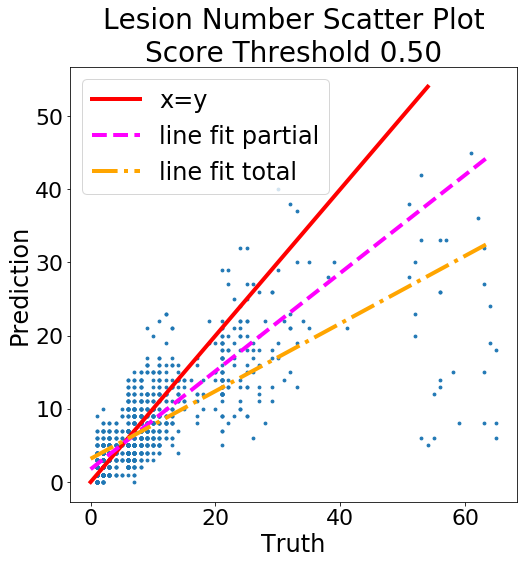

In [88]:
plot_fit(50)

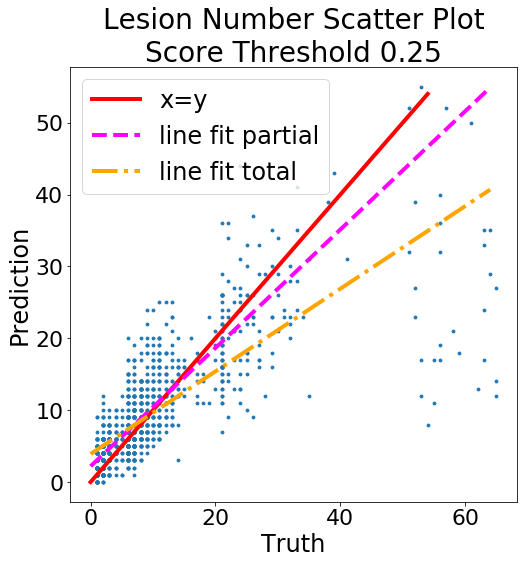

In [89]:
plot_fit(25)

In [71]:
from pycm import *

In [72]:
cm_90 = ConfusionMatrix(actual_vector=df_ann["severity_level"].values, predict_vector=df_ann["res90_lv"].values)
cm_25 = ConfusionMatrix(actual_vector=df_ann["severity_level"].values, predict_vector=df_ann["res25_lv"].values)
cm_50 = ConfusionMatrix(actual_vector=df_ann["severity_level"].values, predict_vector=df_ann["res50_lv"].values)
cm_75 = ConfusionMatrix(actual_vector=df_ann["severity_level"].values, predict_vector=df_ann["res75_lv"].values)

In [74]:
print(cm_90)

Predict   0         1         2         3         
Actual
0         477       5         0         0         

1         425       153       0         0         

2         39        91        2         0         

3         11        19        0         0         





Overall Statistics : 

95% CI                                                            (0.48917,0.5452)
ACC Macro                                                         0.75859
AUNP                                                              0.58977
AUNU                                                              0.55613
Bennett S                                                         0.35625
CBA                                                               0.19523
CSI                                                               None
Chi-Squared                                                       None
Chi-Squared DF                                                    9
Conditional Entropy                         

In [75]:
print(cm_25)

Predict   0         1         2         3         
Actual
0         385       97        0         0         

1         99        467       12        0         

2         0         59        73        0         

3         0         12        15        3         





Overall Statistics : 

95% CI                                                            (0.73544,0.78338)
ACC Macro                                                         0.87971
AUNP                                                              0.79029
AUNU                                                              0.73004
Bennett S                                                         0.67921
CBA                                                               0.54598
CSI                                                               0.38016
Chi-Squared                                                       1131.13301
Chi-Squared DF                                                    9
Conditional Entropy               

In [76]:
print(cm_50)

Predict   0         1         2         3         
Actual
0         435       47        0         0         

1         184       387       7         0         

2         1         93        38        0         

3         1         14        15        0         





Overall Statistics : 

95% CI                                                            (0.67816,0.72937)
ACC Macro                                                         0.85188
AUNP                                                              0.74467
AUNU                                                              0.66866
Bennett S                                                         0.60502
CBA                                                               0.41448
CSI                                                               None
Chi-Squared                                                       None
Chi-Squared DF                                                    9
Conditional Entropy                        

In [77]:
print(cm_75)

Predict   0         1         2         3         
Actual
0         464       18        0         0         

1         285       292       1         0         

2         5         115       12        0         

3         8         14        8         0         





Overall Statistics : 

95% CI                                                            (0.60138,0.65557)
ACC Macro                                                         0.81424
AUNP                                                              0.68039
AUNU                                                              0.61494
Bennett S                                                         0.50464
CBA                                                               0.30126
CSI                                                               None
Chi-Squared                                                       None
Chi-Squared DF                                                    9
Conditional Entropy                        

In [82]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            save_name = "normalized_cm_{}.pdf".format(int(time.time()))
        else:
            title = 'Confusion matrix'
            save_name = "not_normalized_cm_{}.pdf".format(int(time.time()))
            
    if normalize:
        save_name = "normalized_cm_{}.pdf".format(int(time.time()))
    else:
        save_name = "not_normalized_cm_{}.pdf".format(int(time.time()))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     print((unique_labels(y_true.astype(int), y_pred.astype(int))).dtype)
#     classes = classes[unique_labels(y_true.astype(int), y_pred.astype(int))]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
#            title=title,
#            ylabel='True label',
#            xlabel='Predicted label',
        )
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("True severity",fontsize=14)
    ax.set_ylabel("Predicted severity",fontsize=14)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", 
                    fontsize=18)
    fig.tight_layout()
#     plt.savefig(save_name, bbox_inches='tight', transparent=True)
    
    return ax

Confusion matrix, without normalization


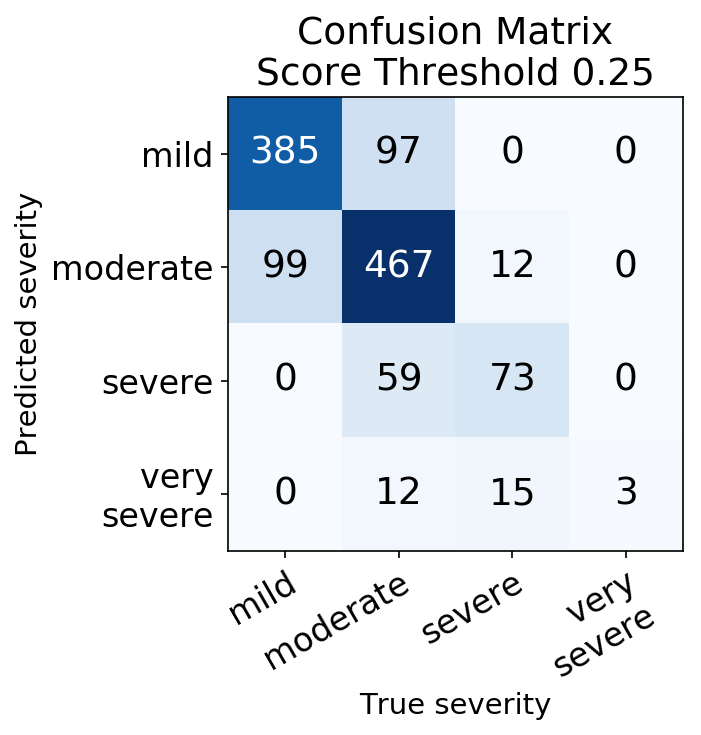

In [85]:
thre = 25

plot_confusion_matrix(df_ann["severity_level"].values, df_ann[f"res{thre}_lv"].values, classes=["mild", "moderate", "severe", "very\nsevere"], title=f"Confusion Matrix\nScore Threshold 0.{thre}")

In [ ]:
len(all_fi)

In [ ]:
[os.path.basename(item) for item in all_fi if os.path.basename(item) not in df_ann['img_ori_name'].values.tolist()]

In [ ]:
import sklearn

sklearn.__version__

In [ ]:
import matplotlib, pyforest
matplotlib.__version__, pyforest.__version__